# Técnicas de deblurring

## Bibliotecas utilizadas

In [1]:
import cv2
from google.colab.patches import cv2_imshow
from numpy.fft import fftn, ifftn, fftshift
import numpy as np

## Funções utilizadas

### Redimensionamento da imagem

In [3]:
def resize_img(img, scale):
  width = int(img.shape[1]*scale/100)
  height = int(img.shape[0]*scale/100)
  dim = (width, height)
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

### Geração do kernel do filtro gaussiano

In [4]:
def gaussian_filter(k=5, sigma=1.0):
    arx = np.arange((-k//2) + 1.0, (k//2) + 1.0)
    x, y = np.meshgrid(arx, arx)
    filt = np.exp(-(1/2) * (np.square(x) + np.square(y))/np.square(sigma))
    return filt/np.sum(filt)

### Convolução do kernel para imagens coloridas

In [26]:
def convolution_rgb(image, kernel_size, sigma):
  B, G, R = cv2.split(image)
  kernel = gaussian_filter(k=kernel_size, sigma=sigma)
  x = int(image.shape[0]//2 - kernel.shape[0]//2)
  y = int(image.shape[1]//2 - kernel.shape[1]//2)
  kernel_pad = np.pad(kernel, [(x,x),(y,y)], 'constant', constant_values=(0))
  H = fftn(kernel_pad)
  F_B = fftn(B)
  F_G = fftn(G)
  F_R = fftn(R)
  convolution_B = np.multiply(F_B,H)
  convolution_G = np.multiply(F_G,H)
  convolution_R = np.multiply(F_R,H)
  B = fftshift(ifftn(convolution_B)).real
  G = fftshift(ifftn(convolution_G)).real
  R = fftshift(ifftn(convolution_R)).real
  convolution_result = cv2.merge((B, G, R))
  images = np.hstack((image, convolution_result))
  cv2_imshow(images)
  return convolution_result

### Convolução do kernel para imagens coloridas

In [27]:
def deconvolution_rgb(img_blurred, kernel_size, sigma):
  B, G, R = cv2.split(img_blurred)
  kernel = gaussian_filter(k=kernel_size, sigma=sigma)
  x = int(image.shape[0]//2 - kernel.shape[0]//2)
  y = int(image.shape[1]//2 - kernel.shape[1]//2)
  kernel_pad = np.pad(kernel, [(x,x),(y,y)], 'constant', constant_values=(0))
  H = fftn(kernel_pad)
  F_B = fftn(B)
  F_G = fftn(G)
  F_R = fftn(R)
  deconvolution_B = np.divide(F_B,H)
  deconvolution_G = np.divide(F_G,H)
  deconvolution_R = np.divide(F_R,H)
  B = fftshift(ifftn(deconvolution_B)).real
  G = fftshift(ifftn(deconvolution_G)).real
  R = fftshift(ifftn(deconvolution_R)).real
  deconvolution_result = cv2.merge((B, G, R))
  images = np.hstack((img_blurred, deconvolution_result))
  cv2_imshow(images)
  return deconvolution_result

## 1 - Deconvolução no domínio da frequência

Essa técica consiste em aplicar a deconvolução de um dado filtro em uma imagem no domínio frequência

Dado que a convolução de um filtro **H** em imagem **F**, originando uma imagem **G** pode ser definida, no domínio da frequência, pela fórmula

<center>$G = F*H$</center>

A operação de deconvolução é definida por

<center>$\hat{F} = \frac{G}{H}$</center>

In [ ]:
image = resize_img(cv2.imread('wine-glass.png', 0), 50)

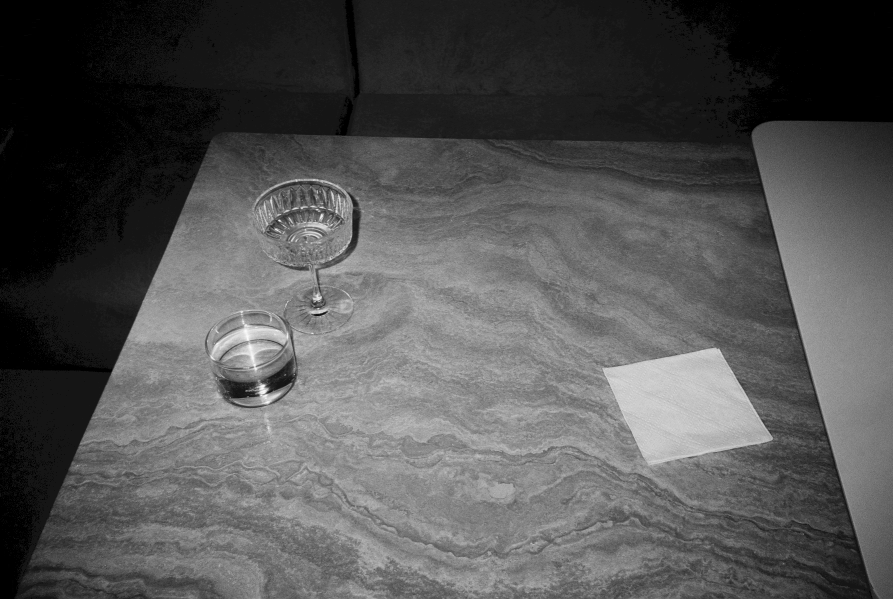

In [ ]:
cv2_imshow(image)

## Operação de convolução no domínio da frequência ($G = F*H$)

### Padding do kernel gaussiano

In [ ]:
kernel = gaussian_filter(k=7, sigma=2)
x = int(image.shape[0]//2 - kernel.shape[0]//2)
y = int(image.shape[1]//2 - kernel.shape[1]//2)
kernel_pad = np.pad(kernel, [(x,x),(y,y)], 'constant', constant_values=(0))

### Transformação da imagem e do kernel para o domínio da frequência

In [ ]:
F = fftn(image)
H = fftn(kernel_pad)

### Aplicação da convolução

In [ ]:
convolution = np.multiply(F,H)

### Transformação do resultado da convolução do domínio da frequência para o domínio do espaço e visualização do resultado

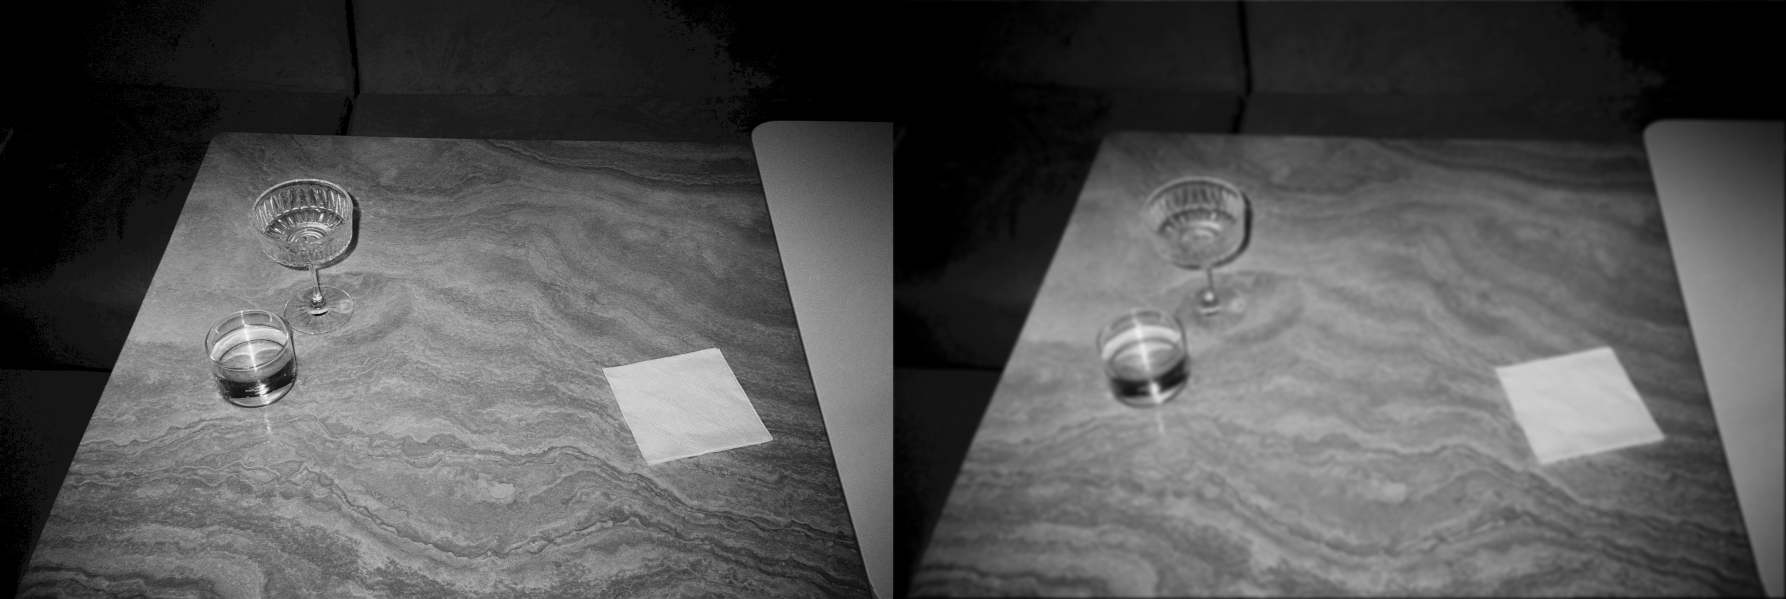

In [ ]:
image_blurred = fftshift(ifftn(convolution).real)
images = np.hstack((image, image_blurred))
cv2_imshow(images)

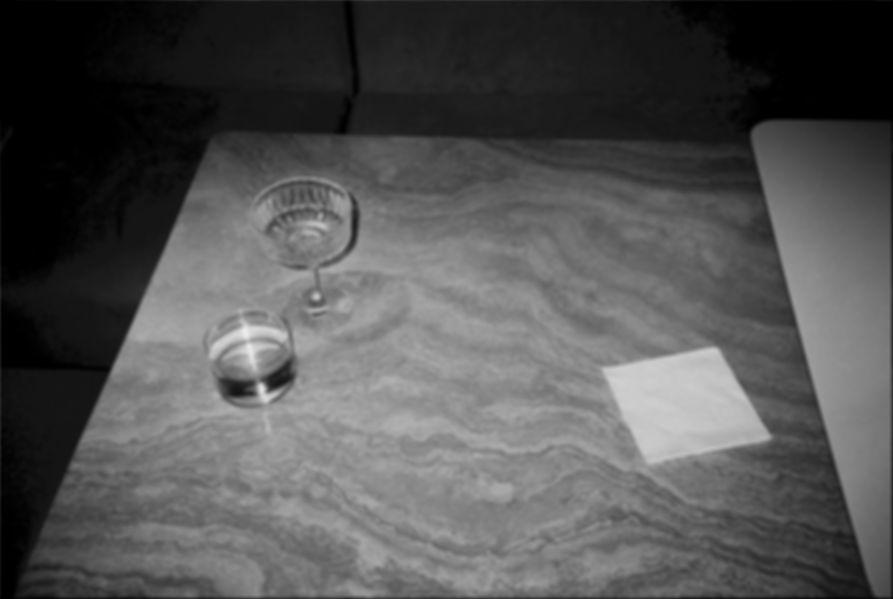

In [ ]:
cv2_imshow(image_blurred)

## Operação de deconvolução no domínio da frequência ($\hat{F} = \frac{G}{H}$)

### Transformação da imagem borrada e do kernel que foi aplicado a ela para o domínio da frequência

In [ ]:
G = fftn(image_blurred)
H = fftn(kernel_pad)

### Operação de deconvolução (retirada do borramento)

In [ ]:
deconvolution = np.divide(G,H)

### Resultado da deconvolução

In [ ]:
deconvolution_result = fftshift(ifftn(deconvolution)).real

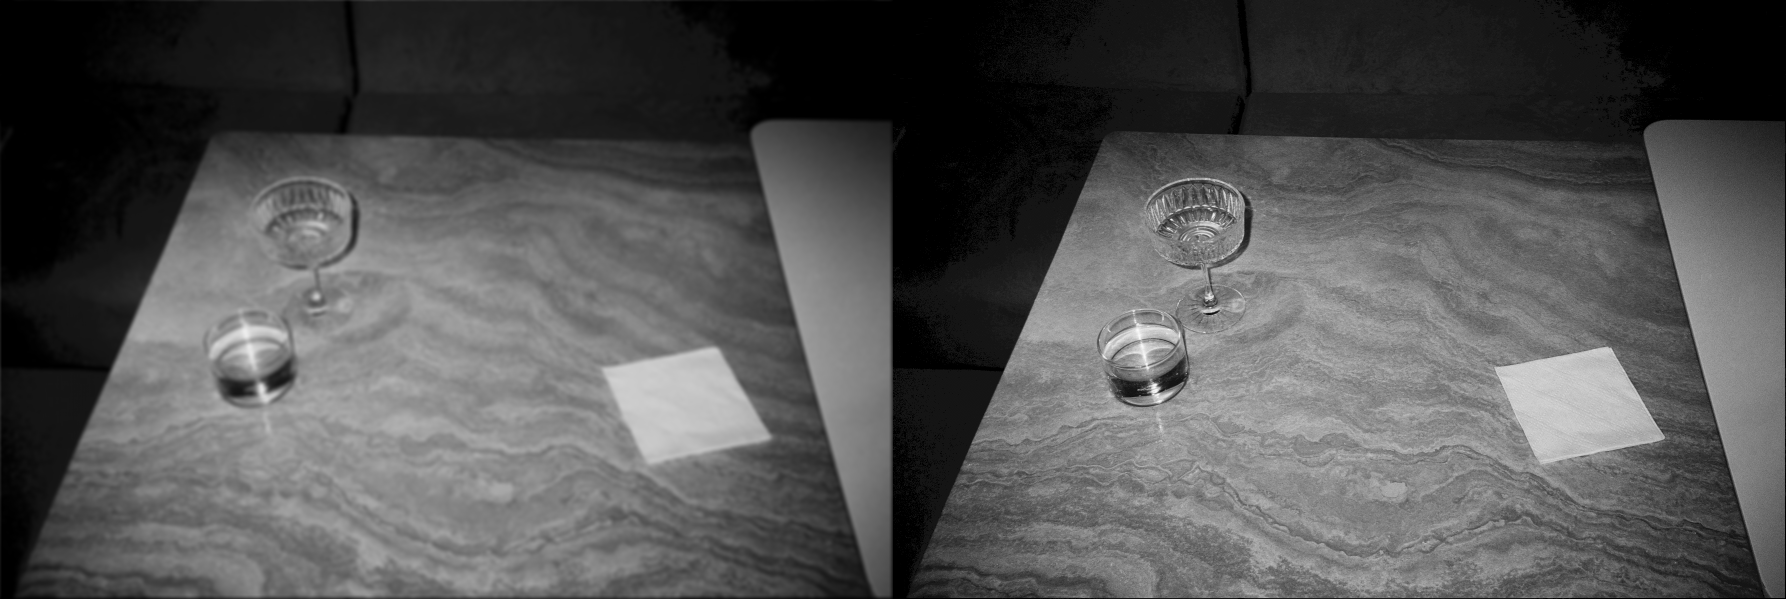

In [ ]:
images = np.hstack((image_blurred, deconvolution_result))
cv2_imshow(images)

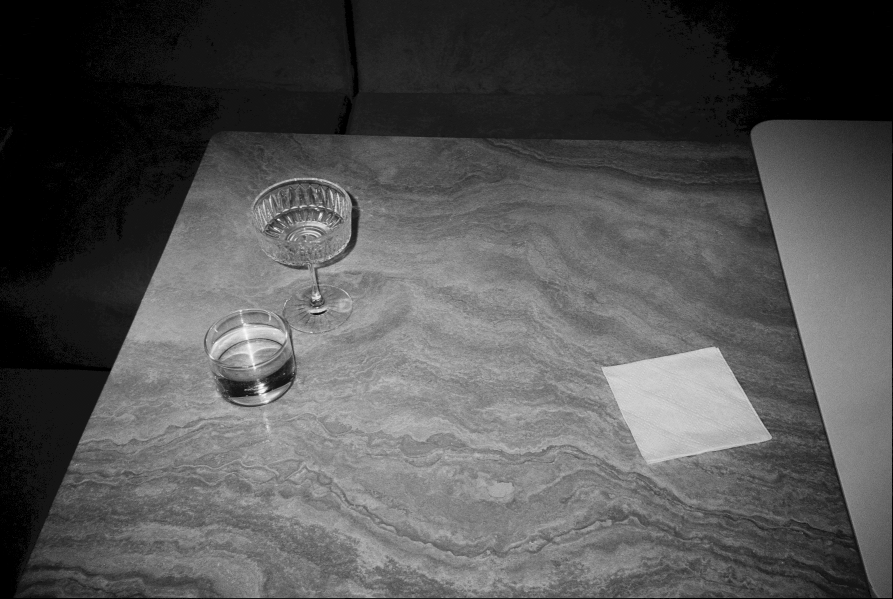

In [ ]:
cv2_imshow(deconvolution_result)

## Aplicação da convolução e deconvolução no kernel domínio da frequência usando as funções **convolution()** e **deconvolution()**

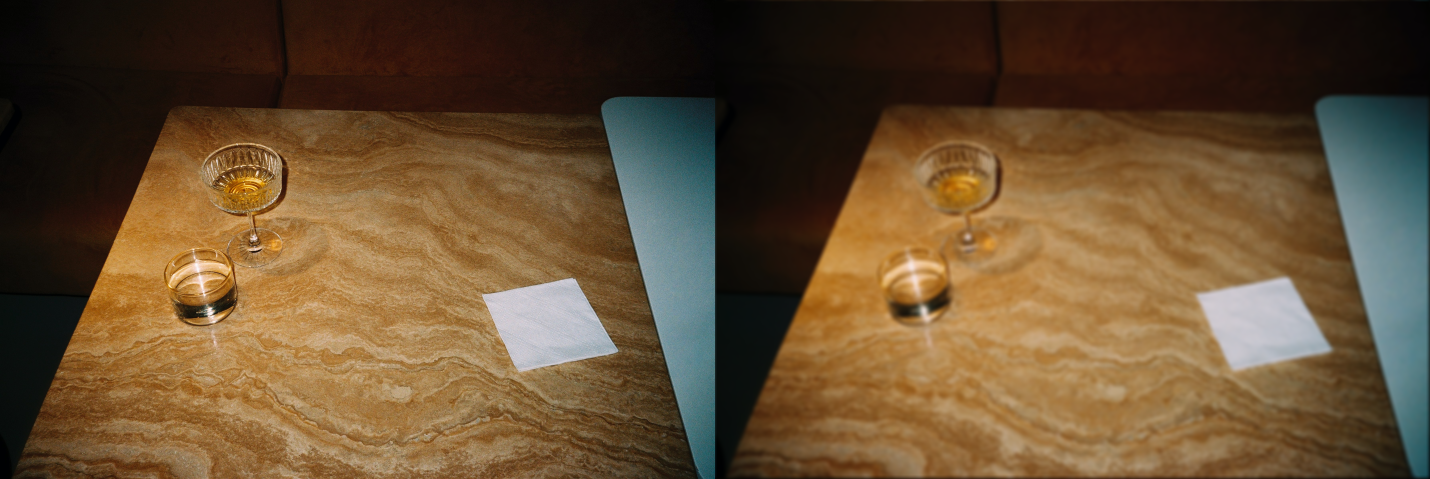

In [28]:
blurred = convolution_rgb(image, 7, 2)

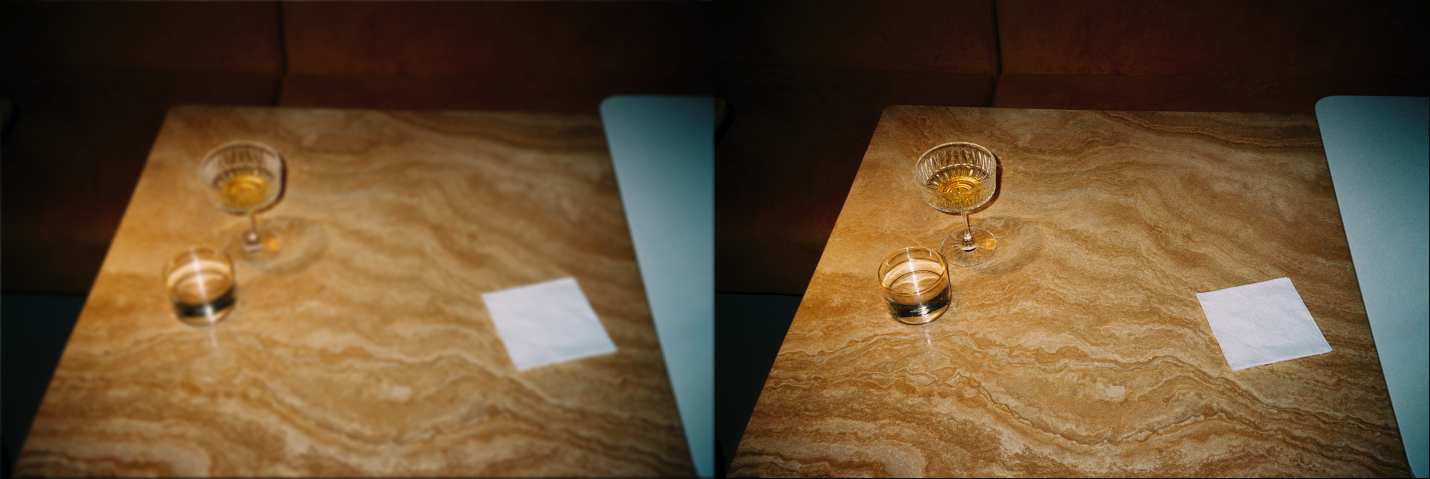

In [30]:
without_blur = deconvolution_rgb(blurred, 7, 2)

## Conclusão

### Dada uma imagem borrada, se pudermos estimar o seu nível de borramento e gerar um kernel correspondente a ele, poderemos remover o borramento da imagem através da **aplicação da deconvolução do kernel no domínio da frequência**